In [ ]:
import scanpy as sc
import pandas as pd
import pySPaRTAN

## 1.2 Clustering and assigning cell-types
SPaRTAN performs best when used to model data from different cell types seperately.  Several methods exist for cell-type assignments from CITE-Seq data.  For the purposes of this demonstration, we use the Leiden algorithm to cluster the data using both gene and protein expression, and then manually map the clusters to cell types based on the mean expression of the marker genes and proteins for each cluster.  The process is ommited here, but shown available on the SPaRTAN Github repository.  

We use the marker genes and proteins in Table X to assign cell types to each cluster.


| Cell Type          | Marker Genes         | Marker Proteins |
|--------------------|----------------------|-----------------|
| CD8+               | CD8A,  CD8B,  FCER1G | CD8a, CD4       |
| Naive CD4+ T       | IL7R,  CCR7,  CD3E   | CD45RA, CD4     |
| Memory CD4+        | IL7R, S100A4, CD3E   | CD45RO, CD4     |
| NK                 | GNLY,  NKG7          | CD56            |
| DC                 | FCER1A, CST3         |                 |
| CD14+ Mono         | CD14, LYZ            | CD14            |
| FCGR3A+/CD16+ Mono | FCGR3A, MS4A7        | CD16            |
| B                  | MS4A1                | CD20,  CD19     |




In [8]:

def join_graphs_max(g1: "sparse.spmatrix", g2: "sparse.spmatrix"):
    """Take the maximum edge value from each graph."""
    out = g1.copy()
    mask = g1 < g2
    out[mask] = g2[mask]

    return out

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/jet/packages/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
... storing 'feature_types' as categorical
... storing 'genome' as categorical


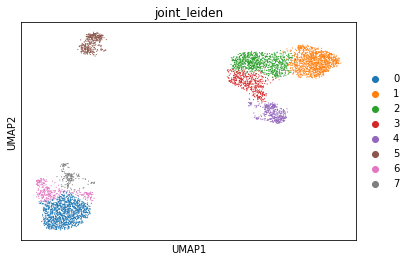

In [9]:
pbmc=sc.read_10x_h5("../data/cite-seq/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
pbmc.var_names_make_unique()
pbmc.layers["counts"] = pbmc.X.copy()
sc.pp.filter_genes(pbmc, min_counts=1)

rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()
rna.var['mt'] = rna.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
rna=rna[rna.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]
rna.layers["normalize_total"]=sc.pp.normalize_total(rna,target_sum=1000000, layer="counts", inplace=False)['X']
sc.pp.log1p(rna)
rna.layers["log1p"]=rna.X

protein = pbmc[rna.obs_names, pbmc.var["feature_types"] == "Antibody Capture"].copy()
protein=protein[:, [ x  for x in protein.var_names if "control" not in x]]
sc.pp.normalize_geometric(protein)
sc.pp.log1p(protein)


sc.pp.pca(protein, n_comps=20)
sc.pp.neighbors(protein, n_neighbors=30)

protein.obsp["protein_connectivities"] = protein.obsp["connectivities"].copy()

sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=30)

rna.obsm["protein"] = protein.to_df()

rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]
rna.obsp["connectivities"] = join_graphs_max(rna.obsp["rna_connectivities"], rna.obsp["protein_connectivities"])

sc.tl.leiden(rna, key_added="joint_leiden")
sc.tl.umap(rna)
sc.pl.umap(rna, color=["joint_leiden"], size=5)



Trying to set attribute `.X` of view, copying.
/jet/packages/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
... storing 'feature_types' as categorical
... storing 'genome' as categorical


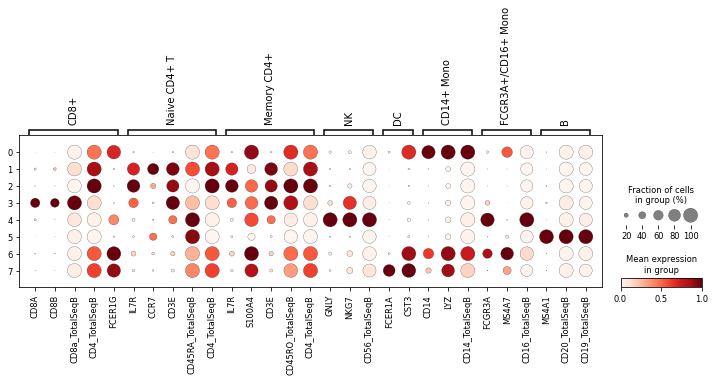

In [10]:
marker_genes={"CD8+": ["CD8A","CD8B","CD8a_TotalSeqB","CD4_TotalSeqB","FCER1G"],
              "Naive CD4+ T": ["IL7R", "CCR7","CD3E","CD45RA_TotalSeqB","CD4_TotalSeqB"],
              "Memory CD4+": ["IL7R", "S100A4","CD3E","CD45RO_TotalSeqB","CD4_TotalSeqB"],
              "NK": ["GNLY", "NKG7", "CD56_TotalSeqB"],
              "DC": ["FCER1A", "CST3"],
              "CD14+ Mono": ["CD14", "LYZ", "CD14_TotalSeqB"],
              "FCGR3A+/CD16+ Mono": ["FCGR3A", "MS4A7", "CD16_TotalSeqB"],
              "B": ["MS4A1", "CD20_TotalSeqB", "CD19_TotalSeqB"]
              }

pbmc=pbmc[rna.obs_names,[ x  for x in pbmc.var_names if "control" not in x]]
pbmc.X[:, (pbmc.var["feature_types"] == "Gene Expression").values] = rna.X
pbmc.X[:, (pbmc.var["feature_types"] == "Antibody Capture").values] = protein.X
pbmc.obsm.update(rna.obsm)
pbmc.obs[rna.obs.columns] = rna.obs


sc.pl.dotplot(  # Should we use z-scores for the hue in these?
    pbmc,
    marker_genes,
    groupby="joint_leiden",
    standard_scale="var"
)

In [11]:
joint_mapping = {
    "0": "CD14+ Mono",
    "1": "CD4+ Naive T",
    "2": "CD4+ Memory T",
    "3": "CD8+",
    "4": "NK",
    "5": "B",
    "6": "FCGR3A+/CD16+ Mono",
    "7": "CD",
}

pbmc.obs["cell_types"] = pbmc.obs["joint_leiden"].map(joint_mapping)

#sc.pl.umap(pbmc, color="cell_types")


In [69]:
cell_types=pbmc.obs["joint_leiden"].map(joint_mapping)
cell_types.name="cell type"
cell_types.to_csv("cell_types_PBMC.csv")

In [1]:
pd.read_csv("cell_types_PBMC.csv", index_col=0)

NameError: name 'pd' is not defined